## _*H2 energy with various RY and RYRZ variational forms*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule using VQE with different variation form configurations. The results are compared to the same energy as computed by the NumPyMinimumEigensolver 

This notebook needs a chemistry driver e.g. PySCF.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import EfficientSU2
from qiskit.providers.aer import AerSimulator
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

var_forms = ['RYRZ', 'RY']
entanglements = ['full', 'linear']
depths = list(range(1, 11))

random_seed = 50
algorithm_globals.random_seed = random_seed

energies = np.empty([len(var_forms), len(entanglements), len(depths)])
hf_energy = None
energy = None
eval_counts = np.empty([len(var_forms), len(entanglements), len(depths)])

H_2 = Molecule(
    geometry=[
        ("H", [0.0, 0.0, 0.0]),
        ("H", [0.0, 0.0, 0.74279]),
    ],
    multiplicity=1,
    charge=0,
)
driver = ElectronicStructureMoleculeDriver(H_2)
problem = ElectronicStructureProblem(driver)
qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=False)
second_q_ops = problem.second_q_ops()
num_particles = problem.num_particles
qubit_operator = qubit_converter.convert(second_q_op=second_q_ops[0], num_particles=num_particles)

result = NumPyMinimumEigensolver().compute_minimum_eigenvalue(operator=qubit_operator)
result = problem.interpret(result)
    
hf_energy = result.hartree_fock_energy
energy = result.total_energies[0]
print('Hartree-Fock energy:', hf_energy)
print('FCI energy:', energy)

Hartree-Fock energy: -1.1166066754855608
FCI energy: -1.1372534440587327


[...]\lib\site-packages\qiskit_nature\problems\second_quantization\electronic\electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


With a reference FCI energy computed from NumPyMinimumEigensolver we now compute the ground state energy with VQE and different variational form setups

In [2]:
print('Processing step __', end='')
for i, d in enumerate(depths):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    for j in range(len(entanglements)):
        for k in range(len(var_forms)):
            variational_form_cls = var_forms[k]

            optimizer = SLSQP(maxiter=10000, ftol=1e-9)
            rotation_blocks = ['ry', 'rz'] if var_forms[k] == 'RYRZ'else 'ry'
            var_form = TwoLocal(qubit_operator.num_qubits, rotation_blocks, 'cz', reps=d, entanglement=entanglements[j])
            
            quantum_instance = QuantumInstance(
                backend=AerSimulator(method='statevector'),
                seed_simulator=random_seed,
                seed_transpiler=random_seed,
            )
            minimum_eigen_solver = VQE(
                ansatz=var_form, quantum_instance=quantum_instance, optimizer=optimizer
            )
            ground_state_solver = GroundStateEigensolver(
                qubit_converter=qubit_converter, solver=minimum_eigen_solver
            )
            result = ground_state_solver.solve(problem=problem)
            eval_counts[k][j][i] = result.raw_result.cost_function_evals
            energies[k][j][i] = result.total_energies[0]
    
print(' --- complete')

print('Depths: ', depths)
print('Energies:', energies)
print('Num evaluations:', eval_counts)

Processing step  9 --- complete
Depths:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Energies: [[[-1.11660668 -1.13725344 -1.11660668 -1.1372534  -1.13725344
   -1.13725344 -1.13725344 -1.13725344 -1.13725344 -1.13725344]
  [-1.11660668 -1.11660668 -1.13725344 -1.13725344 -1.13725306
   -1.13725291 -1.13725344 -1.13725276 -1.13725344 -1.13725344]]

 [[-1.11660668 -1.12661864 -1.13725274 -1.13725344 -1.13725344
   -1.13725344 -1.13725344 -1.13725344 -1.13725344 -1.13725344]
  [-1.11660668 -1.11660668 -1.13725344 -1.13725344 -1.13725344
   -1.13725344 -1.13725344 -1.13725344 -1.13725344 -1.13725344]]]
Num evaluations: [[[ 478.  851. 1222. 4062. 3972. 2395. 2085. 1827. 2272. 2227.]
  [ 393.  752. 2773. 4435. 3677. 7528. 4943. 6499. 5350. 4809.]]

 [[ 244.  826.  718.  717.  850.  786.  529.  667.  658.  946.]
  [ 175.  248.  410.  485.  428.  407.  432.  483.  615.  677.]]]


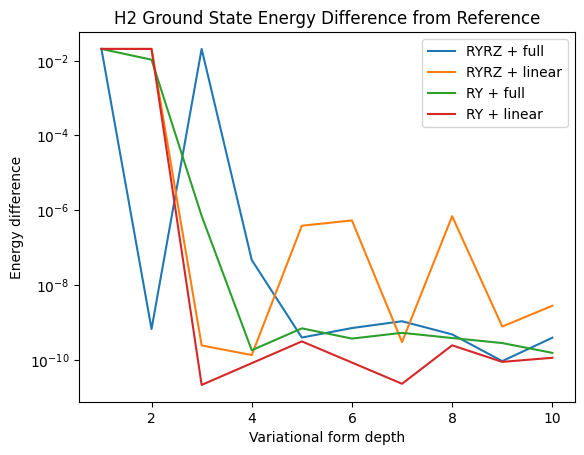

In [3]:
for k in range(len(var_forms)):
    for j in range(len(entanglements)):
        plt.plot(depths, energies[k][j]-energy, label=var_forms[k]+' + '+entanglements[j])
plt.xlabel('Variational form depth')
plt.ylabel('Energy difference')
plt.yscale('log')
plt.title('H2 Ground State Energy Difference from Reference')
plt.legend(loc='upper right')

The above plot shows how close the ground state energy result from VQE was to the reference. The next plot shows how many evaluations (calls to the objective/cost function) were needed by the optimizer before it stopped and returned. Note that the optimzer was configured with a maximum number of iterations of 10,000. SLSQP was chosen as optimizer. Compared to the COBYLA optimizer (which was used in a previous version of this example notebook) SLSQP needs less function evaluations to reach a higher accuracy.

Side note: When switching to a noisy backend gate operation errors are the leading error source. Running this notebook with backend FakeMumbai and the noise resilient SPSA optimizer shows that small circuits are preferred; a variational form depth 1 with energy difference of roughly 10% is the best achievable result for FakeMumbai without sophisticated error mitigation schemes.

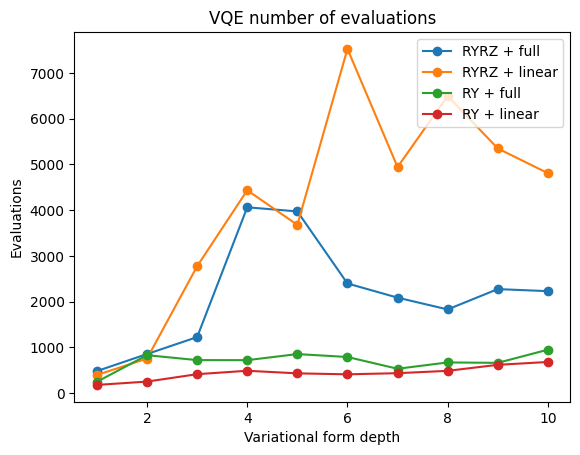

In [4]:
for k in range(len(var_forms)):
    for j in range(len(entanglements)):
        plt.plot(depths, eval_counts[k][j], '-o', label=var_forms[k]+' + '+entanglements[j])
plt.xlabel('Variational form depth')
plt.ylabel('Evaluations')
plt.title('VQE number of evaluations')
plt.legend(loc='upper right')

In [9]:
from qiskit import __qiskit_version__
print(__qiskit_version__)

{'qiskit-terra': '0.21.1', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.1', 'qiskit-nature': '0.4.4', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}
